In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import CNOT_tracker # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx.routing import architecture
from pyzx import circuit

Define a set of helper functions for importing circuits from qasm files, this code is based on some from pyzx_dynqubit/demos/PermRowCol

In [2]:
def read_circuit(source, parity_map=True):
    if not os.path.exists(source):
        print("File {} does not exist".format(source))
        return
    if parity_map:
        return CNOT_tracker.from_qasm_file(source)
    else:
        return circuit.Circuit.from_qasm_file(source)
def read_circuits(directory, n_qubits, parity_map=True):
    source_folder = f"../circuits/{directory}/"
    circuits = []
    sources = []
    subfolder = os.path.join(source_folder, str(n_qubits)+"qubits/")

    for folder in os.listdir(subfolder):
        folder = os.path.join(subfolder, folder)
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if file.endswith(".qasm"):
                    src = os.path.join(folder, file)
                    circuit = read_circuit(src, parity_map)
                    circuits.append(circuit)
                    sources.append(src)
    return circuits, sources

In [3]:
NUM_OF_QUBITS = 5
NUM_OF_GATES = 2
steinerCircuits = read_circuits("steiner", NUM_OF_QUBITS)
steinerCircuits = [steinerCircuits[0][x] for x in range(len(steinerCircuits[0])) if f"{NUM_OF_QUBITS}qubits/{NUM_OF_GATES}/" in steinerCircuits[1][x]]

Create interactive widget to easily see the circuits we have imported

In [4]:
from ipywidgets import widgets
from IPython.display import display, Markdown

def plotter(circ):
    print(f"Circuit Number : {circ}")
    display(zx.draw(steinerCircuits[circ]))
    print(steinerCircuits[circ].matrix.transpose())

w = widgets.interactive(plotter, circ=(0,9))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,30*len(steinerCircuits)))
output = w.children[-1]
output.layout.height = "{!s}px".format(300+NUM_OF_QUBITS*20)
slider.value = 0
w


interactive(children=(IntSlider(value=0, description='circ', layout=Layout(width='800px'), max=9), Output(layo…

Now we are gonna add some phase gates to the parity circuits shown above. This will allow us to figure out how to extract the CNOT combs from them.

In [5]:
NUM_OF_QUBITS = 5
NUM_OF_GATES = 20
circuits = read_circuits("combs", NUM_OF_QUBITS, parity_map=False)
circuits = [circuits[0][x] for x in range(len(circuits[0])) if f"{NUM_OF_QUBITS}qubits/{NUM_OF_GATES}/" in circuits[1][x]]


from ipywidgets import widgets
from IPython.display import display, Markdown

def plotter(circ):
    print(f"Circuit Number : {circ}")
    graph = circuits[circ].to_graph()
    display(zx.draw(graph))
    # display(zx.draw(circuits whjjk wl[circ], h_edge_draw='box'))
    # print(circuits[circ].gates)

w = widgets.interactive(plotter, circ=(0,len(circuits)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,500))
output = w.children[-1]
output.layout.height = "{!s}px".format(400+NUM_OF_QUBITS*20)
slider.value = 0
w

interactive(children=(IntSlider(value=0, description='circ', layout=Layout(width='500px'), max=0), Output(layo…

In [6]:
from pyzx import CombDecomposition
old_circuit = circuits[0]
comb_decomposition = CombDecomposition.from_circuit(old_circuit)

[ 0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0 ]
[ 0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0 ]
[ 0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 ]
[ 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[ 0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0 ]
[ 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 ]
[ 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0 ]
[ 1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ]
[ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ]
[ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ]
bidict({2: 5, 4: 6, 5: 7, 3: 8, 8: 9})


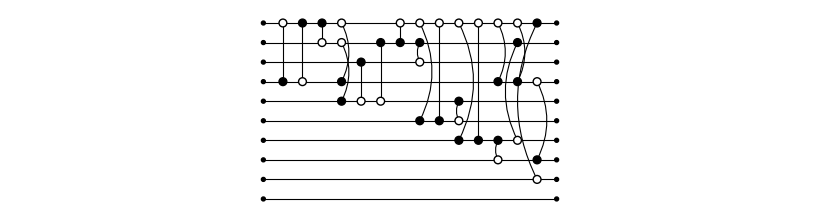

In [7]:
print(comb_decomposition.comb.matrix)
print(comb_decomposition.comb.holes)
zx.draw(comb_decomposition.comb)

In [8]:
new_circuit = CombDecomposition.to_circuit(comb_decomposition)

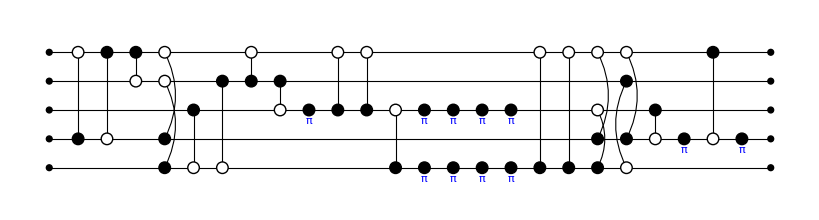

In [9]:
zx.draw(old_circuit)
zx.draw(new_circuit)